In [82]:
import pandas as pd
import numpy as np

In [83]:
data = pd.read_csv('all_points.csv')

In [84]:
data

,id,volume,lon,lat,edd
0,0,0,77.594277,12.971942,2023-02-08
1,1,1000,77.525625,13.003334,2023-02-08
2,2,250,77.600396,12.981320,2023-02-08
3,3,1000,77.638721,13.012191,2023-02-08
4,4,128000,77.616119,12.974993,2023-02-09
...,...,...,...,...,...
2996,2996,64000,77.580650,12.937946,2023-02-10
2997,2997,256000,77.616451,13.000094,2023-02-09
2998,2998,128000,77.608287,12.929386,2023-02-10
2999,2999,2000,77.573500,12.979390,2023-02-11


In [66]:
centers = np.array([[77.640612, 12.971643],
[77.698116, 12.955210],
[77.749481, 12.969120],
[77.625320, 12.927880],
[77.676670, 12.925170],
[77.582000, 12.929200],
[77.625320, 12.927880],
[77.636200, 12.990500],
[77.520000, 13.000000]])

print(centers.shape)

(9, 2)


In [67]:
from sklearn.datasets import make_blobs
x1, y1 = make_blobs(n_samples=3000, centers=centers, n_features=2, cluster_std=0.004)

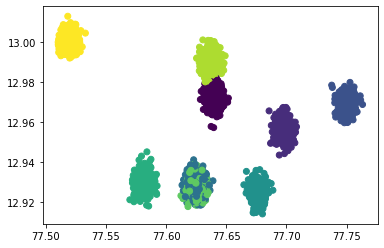

In [68]:
plt.scatter(x1[:,0], x1[:,1], c=y1)

In [170]:
data2 = pd.read_csv('info_lat_long.csv')

In [171]:
data2

,prod_id,edd,lat,long
0,SKU_1,10-02-2023,12.973330,77.652195
1,SKU_10,8-02-2023,12.918786,77.644716
2,SKU_10,07-02-2023,12.969776,77.562318
3,SKU_10,09-02-2023,12.971497,77.634888
4,SKU_10,8-02-2023,12.952243,77.699873
...,...,...,...,...
207,SKU_96,10-02-2023,12.921846,77.540286
208,SKU_97,09-02-2023,13.009845,77.709036
209,SKU_97,11-02-2023,12.962589,77.701680
210,SKU_98,8-02-2023,12.912488,77.585828


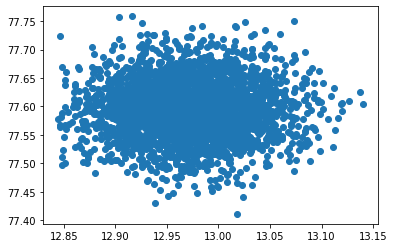

In [85]:
import matplotlib.pyplot as plt

x = data['lat'].to_numpy()
y = data['lon'].to_numpy()

plt.scatter(x,y)
plt.show()

# Second approach

In [86]:
X = np.stack((x,y), axis=1)

In [69]:
X = x1

In [87]:
from sklearn.cluster import DBSCAN, SpectralClustering

def num_clusters(labels):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    return n_clusters, n_noise

def cluster_size(labels):
    labelDict = {}
    for i in labels:
        if i in labelDict:
            labelDict[i] += 1
        else:
            labelDict[i] = 1
    
    max_cluster_size = 0
    min_cluster_size = 100000
    avg_cluster_size = 0
    for k,v in labelDict.items():
        if k == -1:
            continue
        max_cluster_size = max(max_cluster_size, v)
        min_cluster_size = min(min_cluster_size, v)
        avg_cluster_size += v
    
    n_clusters, _ = num_clusters(labels)
    avg_cluster_size /= n_clusters
    return max_cluster_size, min_cluster_size, avg_cluster_size, labelDict

num_of_points = 3000

min_clusters = 1
max_clusters = 20
best_avg_cluster_size = 0
final_clusters = None
minPoints = 20
maxPoints = 400
best_cluster_count = 0
dict_cnt_points = None

bkp_clusters = None
min_max_cluster_size = 3000
cluster_data = None

while min_clusters < max_clusters and min_clusters > 0:
    mid = (min_clusters + max_clusters) // 2
    print(mid)
    clustering = SpectralClustering(n_clusters=mid, assign_labels='discretize', random_state=0)
    #clustering.fit(X1)
    clustering.fit(X)

    max_cluster_size, min_cluster_size, avg_cluster_size, labelDict = cluster_size(clustering.labels_)
    #print(labelDict)

    if max_cluster_size < min_max_cluster_size:
        min_max_cluster_size = max_cluster_size
        bkp_clusters = clustering.labels_
        best_cluster_count = mid
        cluster_data = clustering

    if max_cluster_size > maxPoints:
        min_clusters = mid + 1
    else:
        max_clusters = mid - 1
        if avg_cluster_size > best_avg_cluster_size:
            best_avg_cluster_size = avg_cluster_size
            best_cluster_count = mid
            final_clusters = clustering.labels_
            cluster_data = clustering

if final_clusters is None:
    final_clusters = bkp_clusters

max_cluster_size, _, avg_cluster_size, labelDict = cluster_size(final_clusters)
dict_cnt_points = labelDict
print(best_cluster_count, max_cluster_size, avg_cluster_size)
print(dict_cnt_points)

10
15
18
19
19 1118 157.94736842105263
{9: 1, 4: 331, 1: 1118, 10: 368, 3: 392, 0: 390, 14: 389, 18: 1, 12: 1, 8: 1, 11: 1, 17: 1, 6: 1, 7: 1, 16: 1, 5: 1, 15: 1, 13: 1, 2: 1}


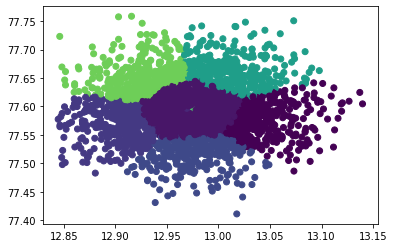

In [88]:
plt.scatter(X[:,0], X[:,1], c=final_clusters)
plt.show()

In [89]:
for lol in range(3):
    new_clusters = {}
    for k,v in dict_cnt_points.items():
        if v <= maxPoints:
            new_clusters[k] = v
        else:
            X_new = []
            pos_new = []
            for i in range(num_of_points):
            #for i in range(3000):
                if k == final_clusters[i]:
                    X_new.append(X[i])
                    pos_new.append(i)
            iter = 3
            val = v
            while iter > 0 and val > maxPoints:
                clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0)
                clustering.fit(X_new)
                max_cluster_size, min_cluster_size, avg_cluster_size, labelDict = cluster_size(clustering.labels_)
                val = max_cluster_size
                #print(best_cluster_count)
                new_clusters[num_of_points] = min_cluster_size
                zero_cnt = labelDict[0]
                one_cnt = labelDict[1]
                miniVal = 0
                if zero_cnt > one_cnt:
                    miniVal = 1

                for i in range(len(clustering.labels_)):
                    if clustering.labels_[i] == miniVal:
                        final_clusters[pos_new[i]] = best_cluster_count
                        if best_cluster_count in new_clusters:
                            new_clusters[best_cluster_count] += 1
                        else:
                            new_clusters[best_cluster_count] = 1
                X_new = []
                pos_new2 = []
                for i in range(len(clustering.labels_)):
                    if clustering.labels_[i] != miniVal:
                        pos_new2.append(pos_new[i])
                        X_new.append(X[pos_new[i]])
                pos_new = pos_new2
                best_cluster_count += 1
                #print(val)
                iter -= 1
            new_clusters[k] = val
    _, _, _, dict_cnt_points = cluster_size(final_clusters)

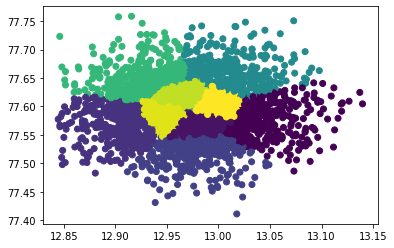

In [90]:
plt.scatter(X[:,0], X[:,1], c=final_clusters)
plt.show()

In [91]:
_, _, _, dict_cnt_points = cluster_size(final_clusters)
dict_cnt_points

{9: 1,
 4: 331,
 21: 263,
 10: 368,
 19: 269,
 20: 287,
 3: 392,
 0: 390,
 14: 389,
 1: 299,
 18: 1,
 12: 1,
 8: 1,
 11: 1,
 17: 1,
 6: 1,
 7: 1,
 16: 1,
 5: 1,
 15: 1,
 13: 1,
 2: 1}

In [92]:
def mean_cluster(cluster):
    x = 0
    y = 0
    n = len(cluster)
    for i in cluster:
        x += X[i][0]
        y += X[i][1]
    x /= n
    y /= n
    return x,y

In [93]:
def generate_clusters(labels):
    res_clusters = {}
    for i in range(len(labels)):
        if dict_cnt_points[labels[i]] <= minPoints:
            continue
        if labels[i] in res_clusters:
            res_clusters[labels[i]].append(i)
        else:
            res_clusters[labels[i]] = [i]
    return res_clusters

clusters_wow = generate_clusters(final_clusters)
mean_clusters = {}

for k,v in clusters_wow.items():
    xC, yC = mean_cluster(v)
    mean_clusters[k] = [xC, yC]

for i in range(len(final_clusters)):
    if dict_cnt_points[final_clusters[i]] <= minPoints:
        correctCluster = -1
        minTmp = 1000000
        for k,v in mean_clusters.items():
            dist = ((v[0] - X[i][0]) ** 2) + ((v[1] - X[i][1]) ** 2)
            if dist < minTmp:
                minTmp = dist
                correctCluster = k
        final_clusters[i] = correctCluster


In [94]:
_, _, _, dict_cnt_points = cluster_size(final_clusters)
dict_cnt_points

{19: 277, 4: 331, 21: 266, 10: 368, 20: 289, 3: 392, 0: 390, 14: 389, 1: 299}

In [95]:
dict_cnt_points_asc = sorted(dict_cnt_points.items(), key=lambda x:x[1])
dict_cnt_points = dict(dict_cnt_points_asc)

print(dict_cnt_points)

{21: 266, 19: 277, 20: 289, 1: 299, 4: 331, 10: 368, 14: 389, 0: 390, 3: 392}


In [96]:
import math

num_of_vehicles = 100

total_points = 0
pmf = {}
for k,v in dict_cnt_points.items():
    total_points += v

for k,v in dict_cnt_points.items():
    pmf[k] = v/total_points

vehicle_cnt_dict = {}
vehicles_left = num_of_vehicles
items_dict = len(pmf)
iteration = 0
for k,v in pmf.items():
    if iteration == items_dict-1:
        vehicle_cnt_dict[k] = vehicles_left
    else:
        if iteration == 0:
            vehicle_cnt_dict[k] = math.ceil(num_of_vehicles * v)
        else:
            vehicle_cnt_dict[k] = math.floor(num_of_vehicles * v)
        iteration += 1
        vehicles_left -= vehicle_cnt_dict[k]

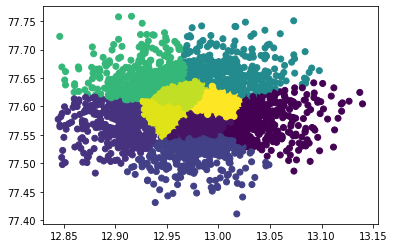

In [97]:
plt.scatter(X[:,0], X[:,1], c=final_clusters)
plt.show()

In [98]:
vehicle_cnt_dict

{21: 9, 19: 9, 20: 9, 1: 9, 4: 11, 10: 12, 14: 12, 0: 12, 3: 17}